
## Описание проекта

Я работаю в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи нашего мобильного приложения. 


## Цель проекта

* Изучить воронку продаж. 
* Дизайнеры захотели поменять шрифты во всём приложении. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Необходимо принять решение по результатам A/A/B-теста и выяснить какой шрифт лучше.

## Описание данных

Каждая запись в логе — это действие пользователя, или событие.

Файл /datasets/logs_exp.csv:
* EventName — название события;
* DeviceIDHash — уникальный идентификатор пользователя;
* EventTimestamp — время события;
* ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

# Загрузка библиотек и глобальных переменных
<a id='id_install'></a>

In [1]:
import pandas as pd
import numpy as np
import warnings

import scipy.stats as st
import math as mth

import matplotlib.pyplot as plt
import seaborn as sns

from numpy import percentile

In [2]:
pd.options.display.float_format = '{: .2f}'.format # отображение 2 знаков после запятой в float
pd.options.display.max_rows = None
pd.options.display.max_columns = None

warnings.filterwarnings("ignore", category=RuntimeWarning)

# Пользовательские функции

Общие ф-ции для проектов анализа данных:

In [3]:
# ф-ция приведения названий столбцов в змеиный регистр
def make_snake_columns(df):
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    return df


# функция первичной проверки данных
def check_data(data_df):
    print ('\033[1m' + 'Изучим исходные данные'+ '\033[0m')
    data_df.info()
    print('\nРазмер датасета:', data_df.shape)

    missed_cells = data_df.isnull().sum().sum()/(data_df.shape[0]*(data_df.shape[1]-1))
    missed_rows = sum(data_df.isnull().sum(axis = 1)>0)/data_df.shape[0]
    print('\033[1m' + '\nПроверка пропусков'+ '\033[0m')
    print('Количество пропусков: {:.0f}'.format(data_df.isnull().sum().sum()))
    print('Доля пропусков: {:.1%}'.format(missed_cells)+ '\033[0m')
    print('Доля строк содержащих пропуски: {:.1%}'.format(missed_rows))

    # Проверим дубликаты
    print ('\033[1m' + '\nПроверка на дубликаты'+ '\033[0m')
    print('Количество полных дубликатов: ', data_df.duplicated().sum())

    # Посмотрим на сами данные
    print ('\033[1m' + '\nПервые 5 строк датасета'+ '\033[0m')
    display(data_df.head())

    # Списки количественных и категориальных столбцов
    numeric_columns = list(data_df.select_dtypes(include=['number']).columns)
    categorical_columns = data_df.select_dtypes(include=['object']).columns

    print('\033[1m' + '\nОписание количественных данных:'+ '\033[0m')
    display(data_df.describe().T)

    if len(categorical_columns) > 0: # проверка на наличие категориальных столбцов
        print('\033[1m' + '\nОписание категориальных данных:'+ '\033[0m')
        display(data_df.describe(include='object').T)

        print('\033[1m' + '\nВывод уникальных значений по каждому категориальному признаку:'+ '\033[0m')
        for i in categorical_columns:
            print('\033[1m' + str(i) + '\033[0m')
            display(data_df[i].value_counts())

Ф-ции для этого проекта

In [4]:

# ф-ция для проведения z-теста и получения p-значения
# возвращает p-значение а также печатает результат теста в случае установки is_print=True (отключено по умолчанию)
def z_test(successes1, trials1, 
           successes2, trials2, 
           alpha, 
           is_print=False # печатать результат?
           ):
    
    p1 = successes1/trials1 # пропорция успехов в первой группе
    p2 = successes2/trials2 # пропорция успехов во второй группе
    p_combined = (successes1 + successes2) / (trials1 + trials2)  # пропорция успехов в комбинированном датасете
    difference = p1 - p2 # разница пропорций в датасетах

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2 # тест двусторонний, поэтому удваиваем результат
    
    if(is_print): # печать результатов

        print('p-значение: ', p_value)

        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
            
    return p_value

# Загрузка данных

In [5]:
url = 'https://code.s3.yandex.net/datasets/'

df  = pd.read_csv(url + 'logs_exp.csv', sep='\t') # логи    


# Первичный осмотр данных

In [6]:
check_data(df)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB

Размер датасета: (244126, 4)

Проверка пропусков
Количество пропусков: 0
Доля пропусков: 0.0%
Доля строк содержащих пропуски: 0.0%

Проверка на дубликаты
Количество полных дубликатов:  413

Первые 5 строк датасета


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
DeviceIDHash,244126.00,4627568124591259648.00,2642424998963961856.00,6888746892508752.00,2372212476992240640.00,4623191541214045184.00,6932517045703054336.00,9222603179720523776.00
EventTimestamp,244126.00,1564913915.84,177134.32,1564029816.00,1564756580.25,1564919395.00,1565074511.00,1565212517.00
ExpId,244126.00,247.02,0.82,246.00,246.00,247.00,248.00,248.00



Описание категориальных данных:


,count,unique,top,freq
EventName,244126,5,MainScreenAppear,119205



Вывод уникальных значений по каждому категориальному признаку:
EventName


EventName
MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: count, dtype: int64

**Краткие итоги:**

Результат первичного осмотра датасета:
* Проверка пропусков - Количество пропусков: 0
* Проверка на дубликаты - Количество полных дубликатов:  413
* В столбце EventName находятся категориальные данные, имеющие 5 значений: MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful и Tutorial 
* В столбце EventTimestamp находятся даты в формате timestamp

**Вывод:**
* Требуется удаление дубликатов
* Требуется приведение названий столбцов в змеиный регистр
* Требуется обработка для использования данных в столбце EventTimestamp


# Подготовка данных

- Заменим названия столбцов на удобные для нас;
- Проверим пропуски и типы данных. Откорректируем, если нужно;
- Добавим столбец даты и времени, а также отдельный столбец дат;

In [7]:
print(list(df.columns))
df.columns = ['event_name', 'device_id_hash', 'event_timestamp', 'exp_id']
print(list(df.columns))

['EventName', 'DeviceIDHash', 'EventTimestamp', 'ExpId']
['event_name', 'device_id_hash', 'event_timestamp', 'exp_id']


In [8]:
duplicates_before = df.duplicated().sum()
rows_before = len(df)

df = df.drop_duplicates()
print(f'Удалено полных дубликатов: {duplicates_before}, это составляет {(duplicates_before/rows_before):.2%} от исходного количества строк')
print('Количество полных дубликатов: ', df.duplicated().sum())

Удалено полных дубликатов: 413, это составляет 0.17% от исходного количества строк
Количество полных дубликатов:  0


In [9]:

df['date_time'] = df['event_timestamp'].astype('datetime64[s]')
df['date'] = df['date_time'].dt.normalize()

# df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype        
---  ------           --------------   -----        
 0   event_name       243713 non-null  object       
 1   device_id_hash   243713 non-null  int64        
 2   event_timestamp  243713 non-null  int64        
 3   exp_id           243713 non-null  int64        
 4   date_time        243713 non-null  datetime64[s]
 5   date             243713 non-null  datetime64[s]
dtypes: datetime64[s](2), int64(3), object(1)
memory usage: 13.0+ MB


**Вывод:**
* Названия столбцов приведены в змеиный регистр;
* Удалены дубликаты
* Добавлен столбец даты и времени, а также отдельный столбец дат;

# Изучение и проверка данных

Ответим на следующие вопросы:
- Сколько всего событий в логе?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?

In [10]:
print(f"Всего событий в логе: {len(df)}, уникальных событий: {df['event_name'].nunique()}")
print(f"Виды событий: {np.unique(df['event_name'])}")
print(f"Всего пользователей в логе: {df['device_id_hash'].nunique()}")
print(f"В среднем на пользователя приходится {( len(df) / df['device_id_hash'].nunique()):.2f} события")

Всего событий в логе: 243713, уникальных событий: 5
Виды событий: ['CartScreenAppear' 'MainScreenAppear' 'OffersScreenAppear'
 'PaymentScreenSuccessful' 'Tutorial']
Всего пользователей в логе: 7551
В среднем на пользователя приходится 32.28 события


Теперь нам необходимо узнать:
- Данными за какой период мы располагаем? Найдем максимальную и минимальную дату. Построим гистограмму по дате и времени.
- Можно ли быть уверенным, что у нас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные».
- Определим, с какого момента данные полные и отбросим более старые. Данными за какой период времени мы располагаем на самом деле?

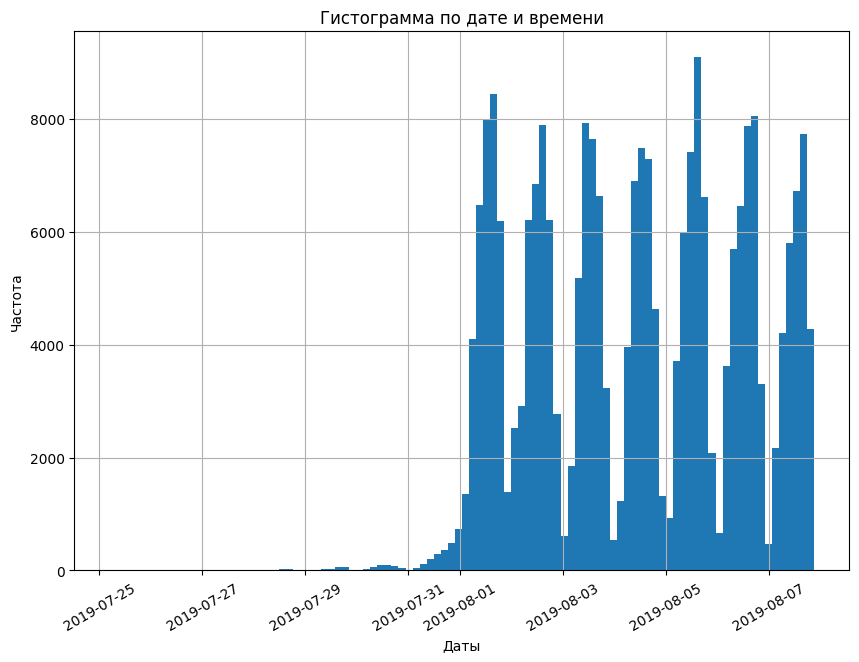

Минимальная дата: 2019-07-25 04:43:36, максимальная дата: 2019-08-07 21:15:17
Q1: 2019-08-02 14:36:45, Q3: 2019-08-06 06:56:24


In [11]:

# fig, (ax0, ax1) = plt.subplots(nrows=1,ncols=2, figsize=(20, 7))
fig, ax0 = plt.subplots(figsize=(10, 7))

df['date_time'].hist(ax=ax0, xrot=30, bins=100)
ax0.set(xlabel='Даты', ylabel='Частота', title='Гистограмма по дате и времени')

# sns.boxplot(data=df['date_time'], ax=ax1, orient='h')
# ax1.set(xlabel='Даты', ylabel='Частота', title='Диаграмма размаха по дате и времени')
# plt.xticks(rotation=30)
plt.show()
 
print(f"Минимальная дата: {df['date_time'].min()}, максимальная дата: {df['date_time'].max()}")
print(f"Q1: {df['date_time'].quantile ( 0.25 )}, Q3: {df['date_time'].quantile ( 0.75 )}")


Исходя из диаграмм, можно утверждать что большинство событий приходится на интервал с 2019-08-01. 
Отбросим нерелевантные данные из прошлого и посмотрим много ли событий и пользователей мы потеряли, отбросив старые данные.

In [12]:
events_before = len(df)
users_count_before = df['device_id_hash'].nunique()

df = df.query("date >= '2019-08-01'") 

print(f"Удалено {events_before - len(df)} событий, что составляет {((events_before - len(df))/events_before):.2%} от исходного количества событий")
print(f"Удалено {users_count_before - df['device_id_hash'].nunique()} пользователей, \
что составляет {((users_count_before - df['device_id_hash'].nunique())/users_count_before):.2%} от исходного количества пользователей")
print(f"Минимальная дата: {df['date'].min()}, максимальная дата: {df['date'].max()}")

Удалено 2826 событий, что составляет 1.16% от исходного количества событий
Удалено 17 пользователей, что составляет 0.23% от исходного количества пользователей
Минимальная дата: 2019-08-01 00:00:00, максимальная дата: 2019-08-07 00:00:00


Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.

In [13]:
df.groupby('exp_id').agg({'device_id_hash':'nunique'})

,device_id_hash
exp_id,
246,2484
247,2513
248,2537


Проверим не попадают ли какие-то пользователи в несколько групп

In [14]:
# проверка не попадают ли какие-то пользователи в несколько групп 
visitors_in_2groups = df.groupby('device_id_hash').agg({'exp_id' : 'nunique'}).query('exp_id > 1').reset_index() 
# print(visitors_in_2groups.head())

print('Количество пользователей, которые присутствуют в нескольких группах: ', len(visitors_in_2groups))
print(f"Это составляет {(len(visitors_in_2groups)/df['device_id_hash'].nunique()):.2%} от общего количества пользователей")

Количество пользователей, которые присутствуют в нескольких группах:  0
Это составляет 0.00% от общего количества пользователей


**Вывод:**
* Минимальная дата: 2019-07-25, максимальная дата: 2019-08-07
* Исходя из диаграмм, можно утверждать что большинство событий приходится на интервал с 2019-08-01, поэтому можно удалить нерелевантные данные за ранние даты
* Удалено 2826 событий, что составляет 1.2% от исходного количества событий
* Удалено 17 пользователей, что составляет 0.2% от исходного количества пользователей
* Количество пользователей, которые присутствуют в нескольких группах:  0
* В датасете присутствуют пользователи из всех трёх экспериментальных групп.

# Изучение воронки событий

Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.

In [15]:
df['event_name'].value_counts(normalize=True)

event_name
MainScreenAppear           0.49
OffersScreenAppear         0.19
CartScreenAppear           0.18
PaymentScreenSuccessful    0.14
Tutorial                   0.00
Name: proportion, dtype: float64

Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

In [16]:

( df.groupby('event_name')['device_id_hash'].nunique() / df.groupby('event_name')['device_id_hash'].nunique().sum()
).reset_index().sort_values(by='device_id_hash', ascending=False)

,event_name,device_id_hash
1,MainScreenAppear,0.37
2,OffersScreenAppear,0.23
0,CartScreenAppear,0.19
3,PaymentScreenSuccessful,0.18
4,Tutorial,0.04


Предположим, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

Ответим на следующие вопросы:
- На каком шаге мы теряем больше всего пользователей?
- Какая доля пользователей доходит от первого события до оплаты?

In [17]:
users_count = df.groupby(['event_name']).agg({'device_id_hash': 'nunique'}).sort_values(by='device_id_hash', ascending=False).reset_index()
users_count['percent_from_prev'] = users_count['device_id_hash'] / users_count['device_id_hash'].shift(1)
users_count['percent_from_first'] = users_count['device_id_hash'] / users_count.loc[0, 'device_id_hash']
# users_count['percent_from_prev'] = users_count['users_percent'].fillna(0)

users_count

,event_name,device_id_hash,percent_from_prev,percent_from_first
0,MainScreenAppear,7419,NaN,1.00
1,OffersScreenAppear,4593,0.62,0.62
2,CartScreenAppear,3734,0.81,0.50
3,PaymentScreenSuccessful,3539,0.95,0.48
4,Tutorial,840,0.24,0.11


Выведем воронку событий на график

In [18]:
from plotly import graph_objects as go
from matplotlib.pyplot import xlabel

data = dict(
            values=users_count.loc[:3,'device_id_hash'],
            events=users_count.loc[:3,'event_name']
            )

fig = go.Figure(go.Funnel(x=data['values'], y=data['events'],
                            textposition = "inside",
                            textinfo = "value+percent initial",))
fig.update_layout(title_text="Воронка событий")
fig.update_xaxes(title_text="Количество пользователей")
fig.update_yaxes(title_text="Событие")
    
fig.show()

**Вывод:**
* В логах присутствуют следующие события по убыванию частоты появления: MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful, Tutorial
* Наиболее часто встречается в логах событие MainScreenAppear: 49%. Частота появления события Tutorial близка к 0.
* События по убыванию доли пользователей, которые их совершали: MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful, Tutorial
* Наибольшая доля пользователей совершала событие MainScreenAppear:	37%. И только 4% пользователей совершали событие Tutorial
* Можно предположить, что события происходят в следующем порядке:
    * MainScreenAppear         
    * OffersScreenAppear        
    * CartScreenAppear           
    * PaymentScreenSuccessful   
    * Tutorial
* Больше всего пользователей теряется на шаге Tutorial, тк до него доходит только 24% пользователей с предыдущего шага
* Шаг Tutorial является опциональным, поэтому в дальнейшем мы исключим его из воронки
* От первого события до оплаты PaymentScreenSuccessful доходит 48% пользователей
* Обнаружена проблема - провал на первом шаге: от MainScreenAppear к OffersScreenAppear. Экран предложений	видит только 62% пользователей. Вероятно, нужно лучше прорабатывать механику, чтобы пользователи переходили к OffersScreen.

# Изучение результатов эксперимента

Удалим событие Tutorial из воронки событий

In [19]:
events_before = len(df)
users_count_before = df['device_id_hash'].nunique()

funnel = df.query('event_name != "Tutorial"')

print(f"Удалено {events_before - len(funnel)} событий, что составляет {((events_before - len(funnel))/events_before):.2%} от исходного количества событий")
print(f"Удалено {users_count_before - funnel['device_id_hash'].nunique()} пользователей, \
что составляет {((users_count_before - funnel['device_id_hash'].nunique())/users_count_before):.2%} от исходного количества пользователей")

Удалено 1005 событий, что составляет 0.42% от исходного количества событий
Удалено 4 пользователей, что составляет 0.05% от исходного количества пользователей


Посмотрим сколько пользователей в каждой экспериментальной группе

In [20]:
display(funnel.groupby('exp_id')['device_id_hash'].nunique()) 


exp_id
246    2483
247    2512
248    2535
Name: device_id_hash, dtype: int64

Среди пользователей нет попавших в несколько групп. Это мы проверили ранее на этапе Изучение и проверка данных.

**Вывод:**
* Количество пользователей в группах: 
    * 246: 2484
    * 247: 2513
    * 248: 2537
* Среди пользователей нет попавших в несколько групп. Это мы проверили ранее на этапе Изучение и проверка данных.

## А/А -тест

Сформулируем гипотезы

* Н0 - различия между группами, совершившими указанное событие, статистически не значимы
* Н1 - различия между группами, совершившими указанное событие, статистически значимы

Пороговое значение уровня стат значимости alpha примем за 5%.

У нас есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247. Для поверки будем использовать следующие критерии.

**Критерии успешного A/A-теста:** 

* Количество пользователей в различных группах различается не более, чем на 1%;
* Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
* Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
* Попавший в одну из групп посетитель остаётся в этой группе до конца теста. Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно.

In [21]:
# проверка разницы в количестве пользователей
group_246 = funnel.query('exp_id == 246').groupby('exp_id')['device_id_hash'].nunique().reset_index()
group_247 = funnel.query('exp_id == 247').groupby('exp_id')['device_id_hash'].nunique().reset_index()

diff = 1 - group_246.loc[0,'device_id_hash'] / group_247.loc[0,'device_id_hash']
print(f'Разница в количестве пользователей между группами 246 и 247: {diff:.2%}')


Разница в количестве пользователей между группами 246 и 247: 1.15%


Количество пользователей в группах различается на ~ 1%. Предполагаем, что для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же. Среди пользователей нет попавших в несколько групп. Это мы проверили ранее на этапе Изучение и проверка данных. Остается проверка различия ключевых метрик

In [22]:
funnel_grp = funnel.pivot_table(index='event_name', columns='exp_id', values='device_id_hash', aggfunc='nunique',  margins=True
               ).sort_values(by=246, ascending=False).reset_index().reindex([1, 2, 3, 4, 0]).reset_index(drop= True)
funnel_grp['246+247'] = funnel_grp[246] + funnel_grp [247]
display(funnel_grp)


exp_id,event_name,246,247,248,All,246+247
0,MainScreenAppear,2450,2476,2493,7419,4926
1,OffersScreenAppear,1542,1520,1531,4593,3062
2,CartScreenAppear,1266,1238,1230,3734,2504
3,PaymentScreenSuccessful,1200,1158,1181,3539,2358
4,All,2483,2512,2535,7530,4995


Проверим, находят ли статистические критерии разницу между выборками 246 и 247 по ключевым метрикам

In [23]:
alpha = 0.05  # критический уровень статистической значимости

aa_test = pd.DataFrame({'event_name' : ['', '', '', ''],
                        '246_247' : [.0, .0, .0, .0],
                        })
for i in range(0, len(funnel_grp)-1):
    
    aa_test.loc[i,'event_name'] = funnel_grp.loc[i,'event_name']
    aa_test.loc[i,'246_247'] = z_test(funnel_grp.loc[i,246], funnel_grp.loc[4,246], 
                                    funnel_grp.loc[i,247], funnel_grp.loc[4,247],
                                    alpha,
                                    )
aa_test.columns = ['События', 'Сравнение 246 и 247']    
aa_test    

,События,Сравнение 246 и 247
0,MainScreenAppear,0.75
1,OffersScreenAppear,0.25
2,CartScreenAppear,0.23
3,PaymentScreenSuccessful,0.11


**Вывод:**
* Проверены все критерии успешного A/A-теста по группам 246 и 247
* Полученные p-значения больше уровня стат значимости, поэтому не получилось отвергнуть нулевую гипотезу. Следовательно, нет оснований считать доли разными

## А/В-тест

Проверим, находят ли статистические критерии разницу между всеми выборками по ключевым метрикам

In [24]:
ab_test = pd.DataFrame({'event_name' : ['', '', '', ''],
                        '246_248' : [.0, .0, .0, .0],
                        '247_248' : [.0, .0, .0, .0],
                        '(246+247)_248' : [.0, .0, .0, .0],
                        })
for i in range(0, len(funnel_grp)-1):
    
    ab_test.loc[i,'event_name'] = funnel_grp.loc[i,'event_name']    
    ab_test.loc[i,'246_248'] = z_test(funnel_grp.loc[i,246], funnel_grp.loc[4,246], 
                                    funnel_grp.loc[i,248], funnel_grp.loc[4,248],
                                    alpha,
                                    )
    ab_test.loc[i,'247_248'] = z_test(funnel_grp.loc[i,247], funnel_grp.loc[4,247], 
                                    funnel_grp.loc[i,248], funnel_grp.loc[4,248],
                                    alpha,
                                    )
    ab_test.loc[i,'(246+247)_248'] = z_test(funnel_grp.loc[i,'246+247'], funnel_grp.loc[4,'246+247'], 
                                    funnel_grp.loc[i,248], funnel_grp.loc[4,248],
                                    alpha,
                                    )
ab_test.columns = ['События', 'Сравнение 246 и 248', 'Сравнение 247 и 248', 'Сравнение 246+247 и 248']    
ab_test    

,События,Сравнение 246 и 248,Сравнение 247 и 248,Сравнение 246+247 и 248
0,MainScreenAppear,0.34,0.52,0.35
1,OffersScreenAppear,0.21,0.93,0.45
2,CartScreenAppear,0.08,0.59,0.19
3,PaymentScreenSuccessful,0.22,0.73,0.61


В этом проекте мы провели 16 проверок нулевых гипотез на одном наборе данных (по 4 гипотезы в каждом АВ тесте – А1А2 тест, А1В тест, А2В тест, (А1+А2)В тест). 
Можно предположить, что при множественной проверке гипотез возрастает групповая вероятность совершить ошибку первого рода FWER (т.е. получить ошибку первого рода хотя бы один раз из всех проверяемых гипотез).

Можно провести корректировку уровня значимости. Для этого используем поправку Шидака

In [25]:
m = 16
alpha_shidak = 1 - (1 - alpha)**(1/m) 
print(f'Стат уровень значимости с поправкой Шидака: {alpha_shidak:.3f}')

Стат уровень значимости с поправкой Шидака: 0.003


**Вывод:**
* Для всех событий и всех пар групп p-значение значительно больше стат уровня значимости с поправкой Шидака = 0.003. Следовательно, нулевую гипотезу не удалось отвергнуть, и шрифт не влияет на взаимодействие пользователя с приложением.

# Общий вывод

* Первичный осмотр данных:
    * Требуется удаление дубликатов
    * Требуется приведение названий столбцов в змеиный регистр
    * Требуется обработка для использования данных в столбце EventTimestamp
* Подготовка данных:
    * Названия столбцов приведены в змеиный регистр;
    * Удалены дубликаты
    * Добавлен столбец даты и времени, а также отдельный столбец дат;
* Изучение и проверка данных:
    * Минимальная дата: 2019-07-25, максимальная дата: 2019-08-07
    * Исходя из диаграмм, можно утверждать что большинство событий приходится на интервал с 2019-08-01, поэтому можно удалить нерелевантные данные за ранние даты
    * Удалено 2826 событий, что составляет 1.2% от исходного количества событий
    * Удалено 17 пользователей, что составляет 0.2% от исходного количества пользователей
    * Количество пользователей, которые присутствуют в нескольких группах:  0
    * В датасете присутствуют пользователи из всех трёх экспериментальных групп.
* Изучение воронки событий:
    * В логах присутствуют следующие события по убыванию частоты появления: MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful, Tutorial
    * Наиболее часто встречается в логах событие MainScreenAppear: 49%. Частота появления события Tutorial близка к 0.
    * События по убыванию доли пользователей, которые их совершали: MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful, Tutorial
    * Наибольшая доля пользователей совершала событие MainScreenAppear:	37%. И только 4% пользователей совершали событие Tutorial
    * Можно предположить, что события происходят в следующем порядке:
        * MainScreenAppear         
        * OffersScreenAppear        
        * CartScreenAppear           
        * PaymentScreenSuccessful   
        * Tutorial
    * Больше всего пользователей теряется на шаге Tutorial, тк до него доходит только 24% пользователей с предыдущего шага
    * Шаг Tutorial является опциональным, поэтому в дальнейшем мы исключим его из воронки
    * От первого события до оплаты PaymentScreenSuccessful доходит 48% пользователей
    * Обнаружена проблема - провал на первом шаге: от MainScreenAppear к OffersScreenAppear. Экран предложений	видит только 62% пользователей. Вероятно, нужно лучше прорабатывать механику, чтобы пользователи переходили к OffersScreen.
* Изучение результатов эксперимента:
    * Количество пользователей в группах: 
        * 246: 2484
        * 247: 2513
        * 248: 2537
    * Среди пользователей нет попавших в несколько групп. Это мы проверили ранее на этапе Изучение и проверка данных.
    * А/А -тест:
        * Проверены все критерии успешного A/A-теста по группам 246 и 247
        * Полученные p-значения больше уровня стат значимости, поэтому не получилось отвергнуть нулевую гипотезу. Следовательно, нет оснований считать доли разными
    * А/В -тест:
        * Для всех событий и всех пар групп p-значение значительно больше стат уровня значимости с поправкой Шидака = 0.003. Следовательно, нулевую гипотезу не удалось отвергнуть, и шрифт не влияет на взаимодействие пользователя с приложением.

